<div class="alert alert-block alert-info">
⚠️All notebooks should start with the following cell ⚠️.
<br>
<br>
This will ensure that the notebook is set in the correct working directory and that all internal modules can be loaded without setting an entry point.
</div>

In [4]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  c:\Users\Jules\Documents\APT\fil-rouge-pollinisateurs\notebooks
Current working directory:  c:\Users\Jules\Documents\APT\fil-rouge-pollinisateurs


Setup notebook

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [6]:
path = "data/raw_data/spipoll.csv"

In [7]:
data = pd.read_csv(path)

C:\Users\Jules\AppData\Local\Temp\ipykernel_13240\822284616.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


# Data viz

## General Bias in the data

In [8]:
restricted_vars = [
    "collection_id",
    "plante_sc",
    "plante_fr",
    "insecte_sc",
    "insecte_fr",
    "temperature",
    "vent",
    "latitude",
    "longitude",
    "nebulosite",
    "collection_heure_debut",
]
df = data[restricted_vars].copy()

In [9]:
var_interet = df["insecte_fr"]

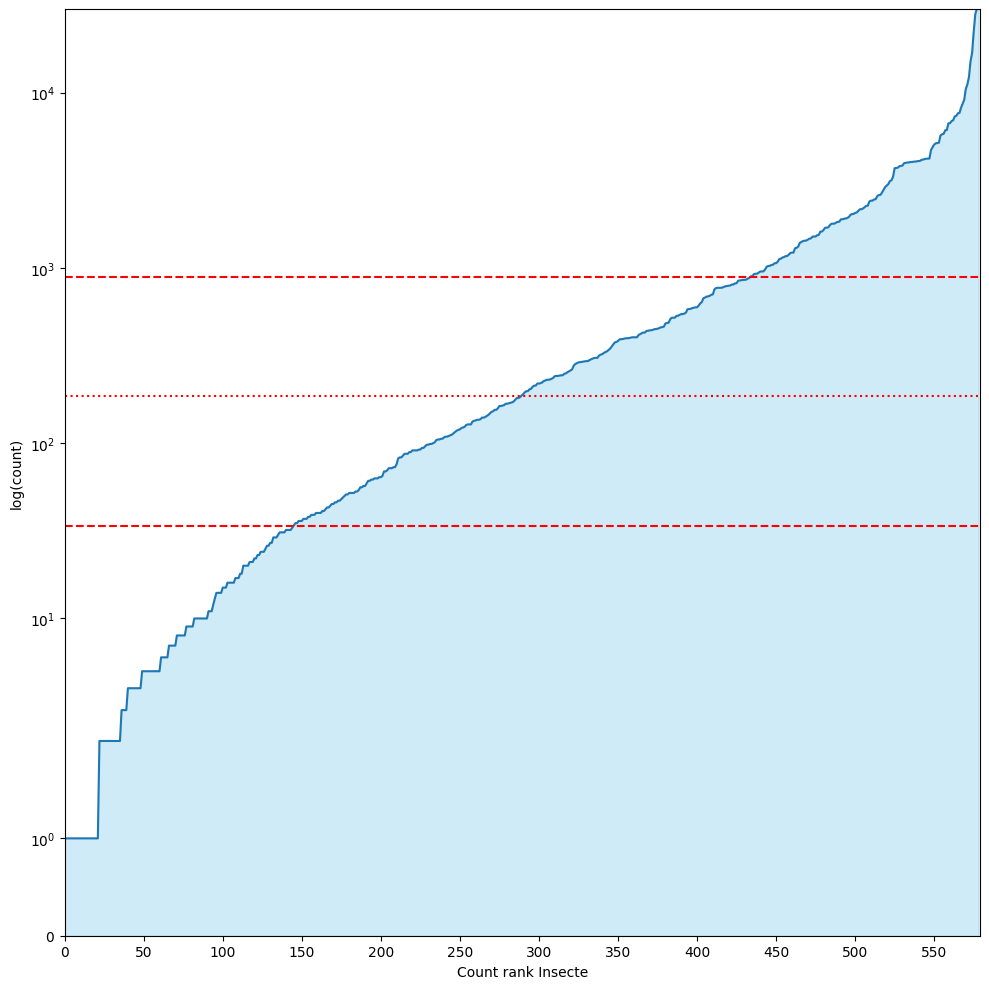

In [10]:
plt.figure(figsize=(10, 10))
x_values = var_interet.dropna().value_counts().index
y_values = var_interet.dropna().value_counts().values[::-1]
sns.lineplot(x=x_values, y=y_values)

# Fill the area under the curve
plt.fill_between(x_values, y_values, color="skyblue", alpha=0.4)

# Put an xtick each 1000 unique values
plt.xticks(range(0, len(var_interet.value_counts()), 50))
# Instead of the label of the xtick, put the position of the xtick
plt.gca().set_xticklabels(range(0, len(var_interet.value_counts()), 50))

# Put a line on the quartiles
plt.axhline(y=var_interet.value_counts().quantile(0.25), color="red", linestyle="--")
plt.axhline(y=var_interet.value_counts().quantile(0.50), color="red", linestyle=":")
plt.axhline(y=var_interet.value_counts().quantile(0.75), color="red", linestyle="--")

plt.ylim(0, 30000)
plt.xlim(0, len(var_interet.value_counts()))
plt.yscale("symlog")
plt.ylabel("log(count)")
plt.xlabel("Count rank Insecte")
plt.tight_layout()
plt.show()

In [11]:
counts = df["insecte_sc"].dropna().value_counts().sort_index()

1/4 des données est très peu représenté sur l'attribut `insecte_sc` `insecte_fr` 

In [12]:
print("insecte_sc")
display(df["insecte_sc"].value_counts().describe())
print("insecte_fr")
display(df["insecte_fr"].value_counts().describe())
# print(
#     f"Proportion NA insecte_SC: {df['insecte_sc'].isna().sum() / len(df['insecte_sc']) * 100:.2f}%"
# )
# print(
#     f"Proportion NA insecte_FR: {df['insecte_fr'].isna().sum() / len(df['insecte_fr']) * 100:.2f}%"
# )

insecte_sc


count      519.000000
mean      1118.512524
std       3112.357440
min          1.000000
25%         31.000000
50%        190.000000
75%        867.000000
max      37429.000000
Name: count, dtype: float64

insecte_fr


count      579.000000
mean      1149.117444
std       3301.689957
min          1.000000
25%         33.500000
50%        187.000000
75%        886.000000
max      48134.000000
Name: count, dtype: float64

In [17]:
# print(df["insecte_sc"].value_counts().head(100).to_dict())

### Visualisation de l'importance de la temporalité

C:\Users\Jules\AppData\Local\Temp\ipykernel_13240\2159321464.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Axes: xlabel='collection_heure_debut', ylabel='Density'>

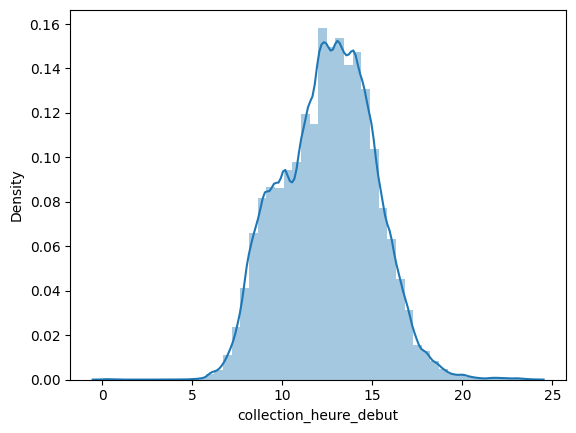

In [14]:
# get samples where collection_heure_debut is between 18 and 08
# knowing data is in this shape  2019-06-12 12:20:00


df["collection_heure_debut"] = pd.to_datetime(df["collection_heure_debut"], format="ISO8601")

# plot the distribution of the collection_heure_debut avec les minutes et les heures en x
# Aggreger collection_id

sns.distplot(
    df["collection_heure_debut"].dt.hour + df["collection_heure_debut"].dt.minute / 60
)

## Distribution de la densité

In [27]:
from models.supervised.preprocessors import MetricsCalculatorNaive

df = data.copy().sample(frac=0.01, random_state=1)

In [28]:
df = MetricsCalculatorNaive(distance = 0.5, clear_intermediate_steps=False).fit_transform(df)

Calculating metrics...


100%|██████████| 6707/6707 [00:10<00:00, 656.40it/s]


In [18]:
df["weighted_specific_richness"].describe()

count    6707.000000
mean        0.462531
std         0.236780
min         0.188851
25%         0.250669
50%         0.396739
75%         0.640000
max         1.200000
Name: weighted_specific_richness, dtype: float64

<Axes: xlabel='weighted_specific_richness', ylabel='Count'>

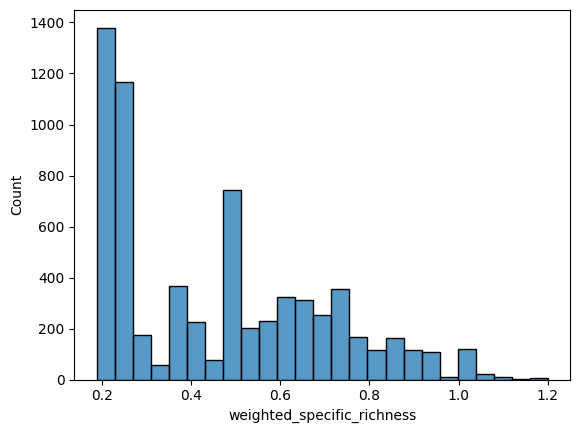

In [20]:
sns.histplot(df["weighted_specific_richness"])

<Axes: xlabel='density', ylabel='Count'>

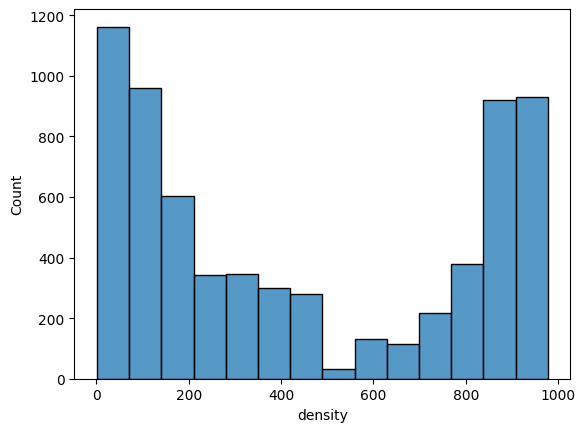

In [26]:
from models.supervised.preprocessors import random_sample_mask

df_t = random_sample_mask(
    df=df,
    column_name="density",
    min_threshold=0,
    max_threshold=0.3,
    sample_percentage=0.3,
)

sns.histplot(df_t["density"])

2613
(6707,)
1306


<Axes: xlabel='weighted_specific_richness', ylabel='Count'>

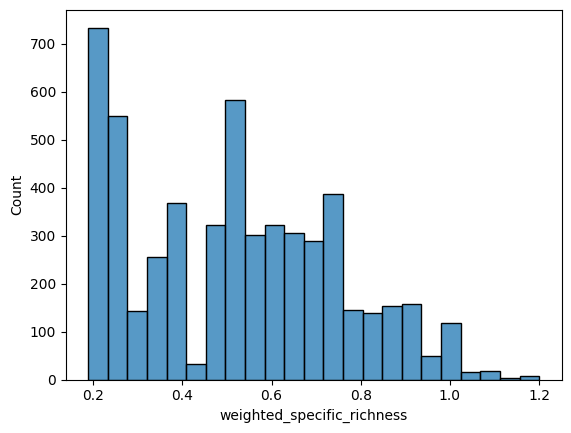

In [21]:
mask = df["weighted_specific_richness"] < 0.3
print(np.count_nonzero(mask))
# Select 30% randomly of the True values in the mask
sample_indices = np.random.choice(df[mask].index, size=int(np.count_nonzero(mask)*0.50), replace=False)
print(mask.shape)
print(len(sample_indices))

# then set the values in the mask to False
mask[sample_indices] = False

# then remove the True values from the dataframe
df_t = df[~mask]


sns.histplot(df_t["weighted_specific_richness"])

C:\Users\Jules\AppData\Local\Temp\ipykernel_2936\3702336448.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["weighted_specific_richness"])


<Axes: xlabel='weighted_specific_richness', ylabel='Density'>

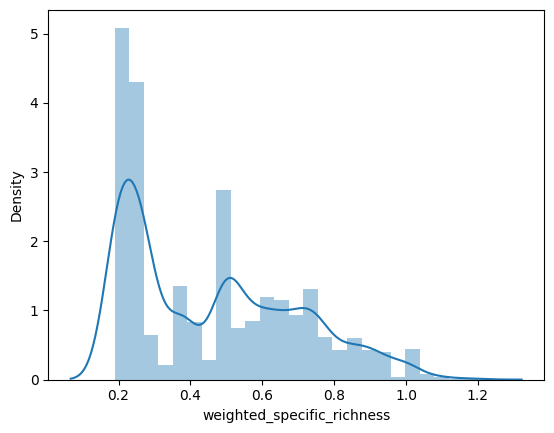

In [53]:
sns.distplot(df["weighted_specific_richness"])

C:\Users\Jules\AppData\Local\Temp\ipykernel_2936\281513181.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["density"])


<Axes: xlabel='density', ylabel='Density'>

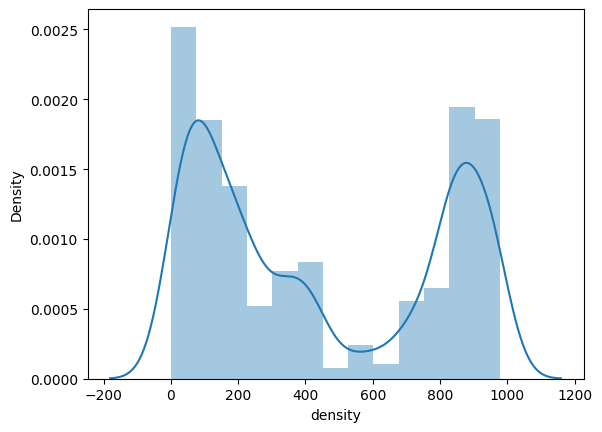

In [23]:
sns.distplot(df["density"])